In [6]:
import pdb
import tensorflow as tf
import numpy as np
import pylab as pl
import pandas as pd

counter=iter(range(10000))

%matplotlib inline

In [7]:
from sklearn.datasets import california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [8]:
california=california_housing.fetch_california_housing()

In [9]:
x=scale(california['data'])
y=california['target']

x=(x-np.mean(x,axis=0))/np.std(x,axis=0)
y=(y-np.mean(y))/np.std(y)

#df=pd.DataFrame(x,columns=california['feature_names'])

In [10]:
# Splitting into train and test sets

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3)

# Random Forest regressor

* Benchmark system
* RF generally gives great performance for problems like this

In [11]:
xtrain.shape

(14448, 8)

In [12]:
rf=RandomForestRegressor(n_estimators=100).fit(xtrain,ytrain)

In [13]:
# MSE Error
np.mean((rf.predict(xtest)-ytest)**2)

0.19237042322183462

# "Deep" Neural Network

* Two hidden layers
* Investigate the effect of different params

In [14]:
nhidden1=250
nhidden2=200
n_iter=1000
activation=tf.nn.relu
#activation=tf.nn.sigmoid

In [15]:
def CreateDN(x,dropKeep,numUnits,resConns=[]):
   
    # Setting things up
    nIn=int(x.shape[1])
    y=x
    l2=0
    
    for layer in range(len(numUnits)):
        
        if layer in resConns:
            w=tf.get_variable("foo"+str(layer),initializer=tf.glorot_normal_initializer(),shape=(nIn,numUnits[layer]))
            w=tf.divide(w,2.,name="w"+str(layer))
        else:
            w=tf.get_variable("w"+str(layer),initializer=tf.glorot_normal_initializer(),shape=(nIn,numUnits[layer]))
            #w=tf.divide(w,2.,name="w"+str(layer))

        b=tf.get_variable('b'+str(layer),initializer=tf.zeros_initializer(),shape=(numUnits[layer]))
        
        #print(w)
        
        if layer in resConns:
            a=tf.add(tf.add(tf.matmul(y,w),b),y,name="a"+str(layer))
        else:
            a=tf.add(tf.matmul(y,w),b,name="a"+str(layer))
        
        #tmpmean=tf.Variable(tf.zeros((1,numUnits[layer])))
        #tmpvar=tf.Variable(tf.ones((1,numUnits[layer])))
        #a=tf.nn.batch_normalization(a,tmpmean,tmpvar,None,None,0.000000000001,name="a"+str(layer))
        #print(str(a))
        
        if layer==len(numUnits)-1:
            y=a
        else:
            y=tf.nn.elu(a)
            y=tf.nn.dropout(y,keep_prob=dropKeep)
    
        l2+=tf.reduce_sum(w**2)
    
        # Prepping for next layer, if present
        nIn=numUnits[layer]
        
    return y,l2

In [34]:
tf.reset_default_graph()

n_iter=2000

nx=tf.placeholder(tf.float32,(None,8))
dk=tf.placeholder(tf.float32,())
target=tf.placeholder(tf.float32,(None,1))

#ny,l2=CreateDN(nx,dk,[256,256,64,1]) # <- this one already gives better results that RF
#ny,l2=CreateDN(nx,dk,[256,256,256,256,64,1],resConns=[2,3])
ny,l2=CreateDN(nx,dk,[128,64,32,32,1]) #,resConns=[4])

testloss=tf.losses.mean_squared_error(ny,target)
loss=testloss+l2*.0
opt=tf.train.AdamOptimizer(learning_rate=.01).minimize(loss)

In [41]:
try: sess.close()
except: pass

sess=tf.Session()
    
writer = tf.summary.FileWriter("/home/wlwoon/tmp/day14log", sess.graph)
sess.run(tf.global_variables_initializer())

es=[]
for count in range(n_iter):
        
    _,tloss=sess.run([opt,loss],feed_dict={dk:.6,nx:xtrain,target:ytrain.reshape((-1,1))})
      
    if count % 50 ==0:
        test_loss=sess.run(testloss,feed_dict={dk:1.0,nx:xtest,target:ytest.reshape((-1,1))})
        print("iter #"+str(count)+", training loss is "+str(tloss)+", test loss is "+str(test_loss))
        es.append(test_loss)

writer.flush()

iter #0, training loss is 1.07391, test loss is 0.615397
iter #50, training loss is 0.343715, test loss is 0.292776


KeyboardInterrupt: 

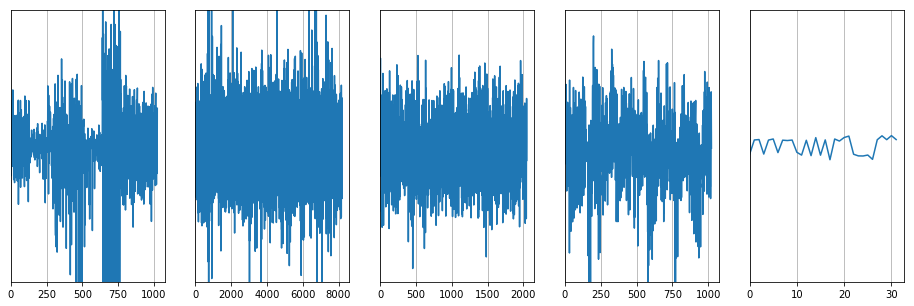

iter #0, training loss is 0.310814, test loss is 0.266182


In [116]:
# Visualize activations
#sess.close();sess=tf.Session();sess.run(tf.global_variables_initializer());counter=iter(range(1000))

g=tf.get_default_graph()
acts=[g.get_tensor_by_name(name='a'+str(tmp)+":0") for tmp in range(5)]
wts=[g.get_tensor_by_name(name='w'+str(tmp)+":0") for tmp in range(5)]

z=pl.figure(figsize=(16,5))
for tmp in range(5):
    pl.subplot(1,5,tmp+1)
    #foo=pl.hist(sess.run(acts[tmp],feed_dict={dk:1,nx:xtest}).flatten(),bins=50)
    foo=pl.plot(sess.run(wts[tmp]).flatten()); #,feed_dict={dk:1,nx:xtest}).flatten())
    pl.gca().set_yticks([])
    #pl.axis(xmin=-3,xmax=3,ymin=-2,ymax=2) # for activations
    pl.axis(xmin=0,ymin=-.5,ymax=.5) # for weights
    pl.grid('on')
    
pl.show()
z.savefig('f'+str(next(counter))+'png')

n_iter=50

es=[]
for count in range(n_iter):
        
    _,tloss=sess.run([opt,loss],feed_dict={dk:.6,nx:xtrain,target:ytrain.reshape((-1,1))})
      
    if count % 50 ==0:
        test_loss=sess.run(testloss,feed_dict={dk:1.0,nx:xtest,target:ytest.reshape((-1,1))})
        print("iter #"+str(count)+", training loss is "+str(tloss)+", test loss is "+str(test_loss))
        es.append(test_loss)

writer.flush()

In [96]:
sess.run(wts[0]).flatten().shape

(1024,)

In [180]:
exec("es"+str(next(counter))+"=es")

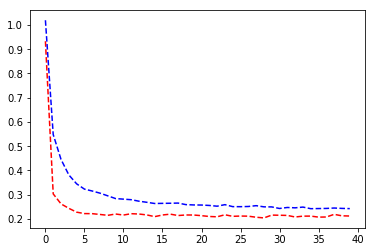

In [169]:
%matplotlib inline
#pl.plot(es1)
#pl.plot(es2,'r')
#pl.plot(es3,'k--')
pl.plot(es4,'r--')
pl.plot(es7,'b--')


In [65]:
%matplotlib tk
z=sess.run(acts[2],feed_dict={dk:1,nx:xtest})

In [67]:
z=sess.run(acts[2],feed_dict={dk:1,nx:xtest})
((z<0).sum(axis=0))/z.shape[0]

array([0.47141473, 0.24870801, 0.58187984, 0.84366925, 0.44266796,
       0.65423127, 0.66602067, 0.62112403, 0.27664729, 0.59593023,
       0.60206718, 0.7495155 , 0.81476098, 0.6498708 , 0.59786822,
       0.25242248, 0.82784238, 0.31605297, 0.31524548, 0.50726744,
       0.64518734, 0.69928941, 0.75113049, 0.47076873, 0.51082041,
       0.60723514, 0.56895995, 0.54602713, 0.29505814, 0.33301034,
       0.8628876 , 0.77955426])

In [27]:
#sess=tf.Session();sess.run(tf.global_variables_initializer())
g=tf.get_default_graph()
acts=[g.get_tensor_by_name(name='a'+str(tmp)+":0") for tmp in range(5)]

pl.figure(figsize=(16,5))
for tmp in range(5):
    pl.subplot(1,5,tmp+1)
    foo=pl.hist(sess.run(acts[tmp],feed_dict={dk:1,nx:xtest}).flatten(),bins=50)
    pl.gca().set_yticks([])
    pl.grid('on')
    
pl.show()



SyntaxError: invalid syntax (<ipython-input-27-20048e104192>, line 14)

In [38]:
?ca.set_xticks

In [130]:
np.mean(ytest**2)
np.std(xtest,axis=0)

array([ 1.02065714,  0.99876618,  0.84249565,  0.74652804,  1.00117305,
        1.54552267,  1.00237812,  0.99950791])